# LLM vs XGBoost Feature Importance Analysis
This notebook compares feature importances from LLMs and XGBoost.

In [1]:

import pandas as pd
import os
import json
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# JSON directories provided by the user
llm_json_dir = r'C:\Users\nehan\Documents\GT\CS 4641\ML_vs_LLM_COVID_GenderBias\Feature Importance Output Files\LLM'
xgb_json_dir = r'C:\Users\nehan\Documents\GT\CS 4641\ML_vs_LLM_COVID_GenderBias\Feature Importance Output Files\CML'

llm_json_files = glob.glob(f"{llm_json_dir}/*.json")
xgb_json_files = glob.glob(f"{xgb_json_dir}/*.json")

json_files = llm_json_files + xgb_json_files

## Load and preprocess JSON files into DataFrame

In [ ]:
all_data = []
for filepath in json_files:
    filename = os.path.basename(filepath)
    parts = filename.replace(".json", "").split("_")

    if parts[0].lower() == 'xgboost':
        model_type, gender_dist, target = 'XGBoost', parts[1], "_".join(parts[2:])
    else:
        if len(parts) == 4:
            model_type, _, gender_dist, target = parts  # Disregard cotr!!!!!!!! (naming convention differs)
        elif len(parts) == 3:
            model_type, gender_dist, target = parts
        else:
            print(f"Unexpected filename format: {filename}")
            continue  

    with open(filepath, 'r') as f:
        feature_weights = json.load(f)

    for feature, weight in feature_weights.items():
        all_data.append({
            "Model": model_type,
            "GenderDistribution": gender_dist,
            "Target": target.lower(),
            "Feature": feature.replace("Immunsupr", "Inmsupr"),
            "Importance": weight
        })

df = pd.DataFrame(all_data)
df.head()


,Model,GenderDistribution,Target,Feature,Importance
0,Chatgpt,AllFemalePregnant,covid-19presence,ICU,0.12
1,Chatgpt,AllFemalePregnant,covid-19presence,Intubed,0.11
2,Chatgpt,AllFemalePregnant,covid-19presence,Obesity,0.10
3,Chatgpt,AllFemalePregnant,covid-19presence,Diabetes,0.09
4,Chatgpt,AllFemalePregnant,covid-19presence,Hypertension,0.09


## Average Feature Importance across all outputs/LLMs by Gender Distribution vs XGBoost

In [38]:
# Group LLMs (not including XGBoost) by GenderDistribution and Feature
df_llm_avg = df[df["Model"] != "XGBoost"].groupby(["GenderDistribution", "Feature"]).Importance.mean().reset_index()

# Group XGBoost by GenderDistribution and Feature
df_xgb_avg = df[df["Model"] == "XGBoost"].groupby(["GenderDistribution", "Feature"]).Importance.mean().reset_index()

# Merge LLM and XGBoost average importance for comparison
comparison_avg_df = pd.merge(
    df_llm_avg,
    df_xgb_avg,
    on=["GenderDistribution", "Feature"],
    suffixes=("_LLMs", "_XGB")
)

comparison_avg_df.head()

,GenderDistribution,Feature,Importance_LLMs,Importance_XGB
0,AllFemale,Age,0.154708,0.3425
1,AllFemale,Asthma,0.040625,0.0200
2,AllFemale,COPD,0.077042,0.0250
3,AllFemale,Cardiovascular,0.067583,0.0250
4,AllFemale,Diabetes,0.072667,0.0400


## Heatmap of Average Feature Importance across all outputs by Gender Distribution and COTR (LLM vs XGBoost)

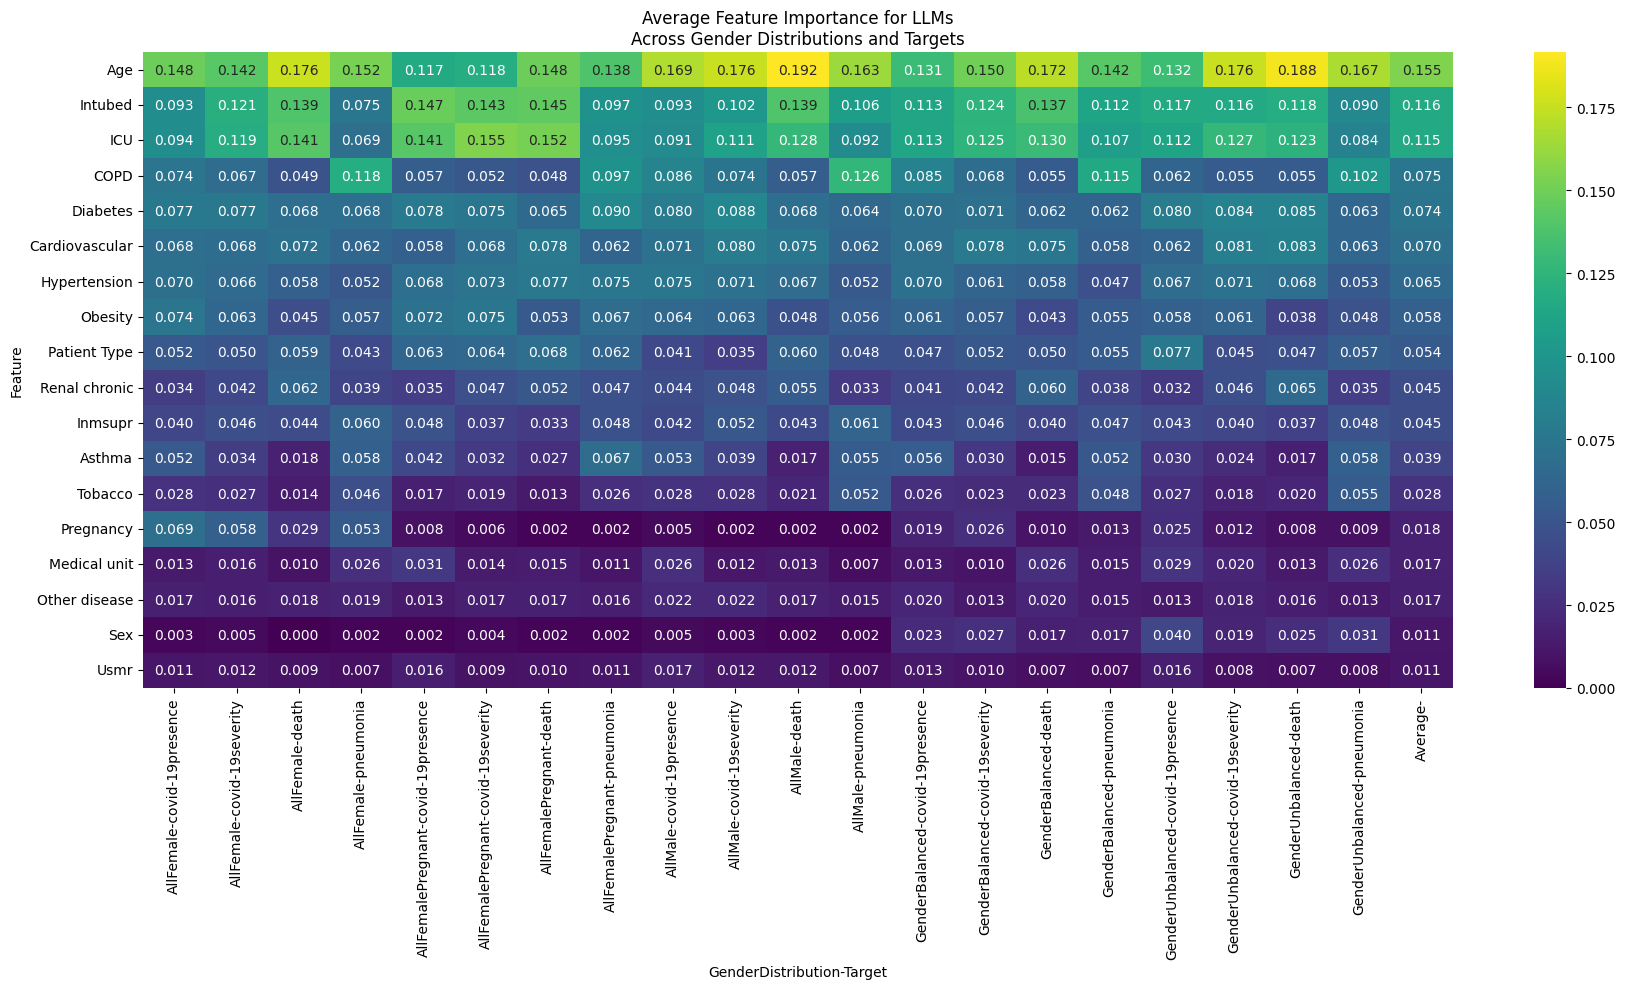


Top 5 Most Important Features (LLMs):

Feature
Age         0.154813
Intubed     0.116295
ICU         0.115432
COPD        0.075031
Diabetes    0.073807
Name: Average, dtype: float64


<Figure size 640x480 with 0 Axes>

In [41]:
#filter dataframe for only llm models
df_llm = df[df["Model"] != "XGBoost"]

# feature × (GenderDistribution + Target)
pivot_llm = df_llm.pivot_table(
    values="Importance",
    index="Feature",
    columns=["GenderDistribution", "Target"],
    aggfunc="mean"
)

# avg importance across all gender/target combinations
pivot_llm["Average"] = pivot_llm.mean(axis=1)

# Sort features by average importance
pivot_llm_sorted = pivot_llm.sort_values(by="Average", ascending=False)

plt.figure(figsize=(18, 10))
sns.heatmap(pivot_llm_sorted, annot=True, cmap="viridis", fmt=".3f")
plt.title("Average Feature Importance for LLMs\nAcross Gender Distributions and Targets")
plt.tight_layout()
plt.show()
plt.savefig("llm_feature_importance_heatmap.png")

# top 5 most important features for llm 
top_5_llm = pivot_llm_sorted["Average"].head(5)
print("\nTop 5 Most Important Features (LLMs):\n")
print(top_5_llm)


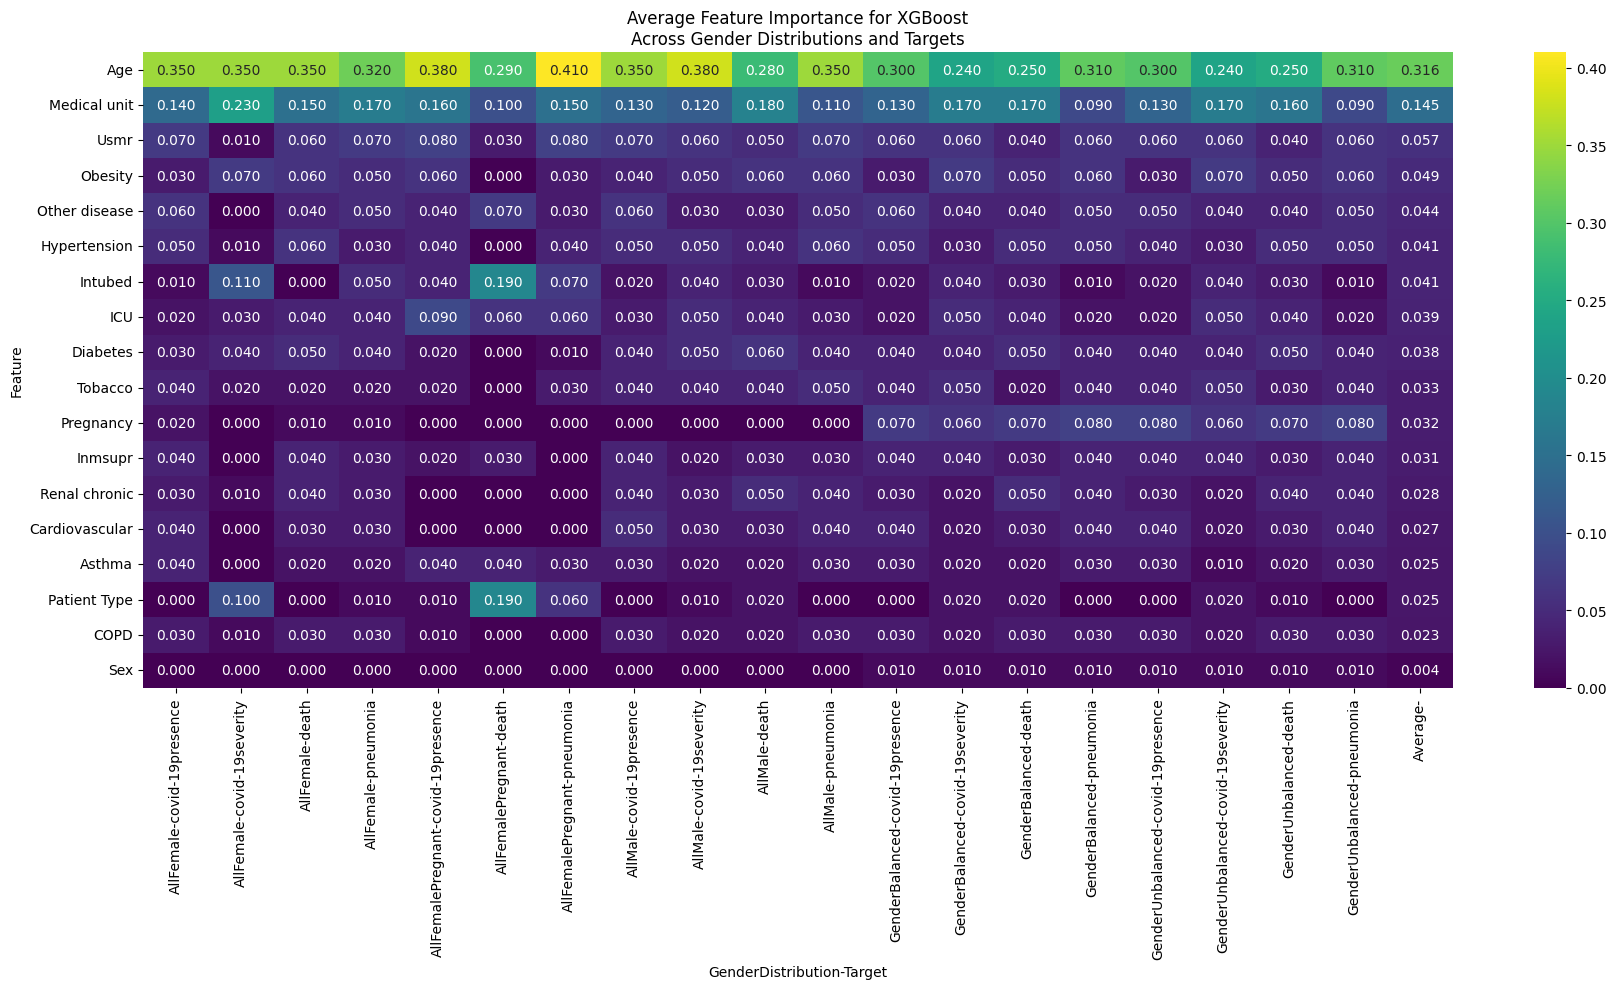


Top 5 Most Important Features (XGBoost):

Feature
Age              0.316316
Medical unit     0.144737
Usmr             0.057368
Obesity          0.048947
Other disease    0.043684
Name: Average, dtype: float64


<Figure size 640x480 with 0 Axes>

In [42]:
# Filter DataFrame to include only XGBoost
df_xgb = df[df["Model"] == "XGBoost"]

# Pivot table: Feature × (GenderDistribution + Target)
pivot_xgb = df_xgb.pivot_table(
    values="Importance",
    index="Feature",
    columns=["GenderDistribution", "Target"],
    aggfunc="mean"
)

# Average importance across all gender/target combinations
pivot_xgb["Average"] = pivot_xgb.mean(axis=1)

# Sort features by average importance
pivot_xgb_sorted = pivot_xgb.sort_values(by="Average", ascending=False)

# Plot heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(pivot_xgb_sorted, annot=True, cmap="viridis", fmt=".3f")
plt.title("Average Feature Importance for XGBoost\nAcross Gender Distributions and Targets")
plt.tight_layout()
plt.show()
plt.savefig("xgboost_feature_importance_heatmap.png")


# Top 5 most important features for XGBoost
top_5_xgb = pivot_xgb_sorted["Average"].head(5)
print("\nTop 5 Most Important Features (XGBoost):\n")
print(top_5_xgb)

## Heatmap of Feature Importance Averages (LLMs vs XGBoost)

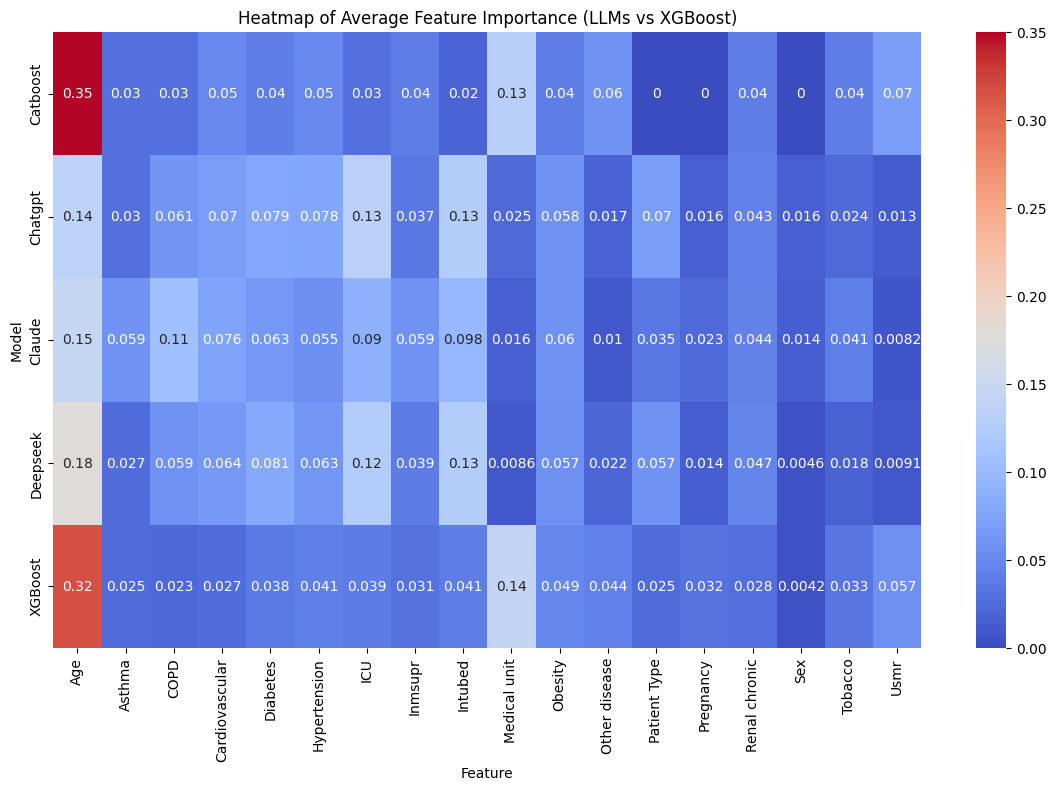

<Figure size 640x480 with 0 Axes>

In [43]:

heatmap_df = df.groupby(["Model", "Feature"]).Importance.mean().reset_index()
heatmap_df_pivot = heatmap_df.pivot(index="Model", columns="Feature", values="Importance").fillna(0)

plt.figure(figsize=(14,8))
sns.heatmap(heatmap_df_pivot, annot=True, cmap="coolwarm")
plt.title("Heatmap of Average Feature Importance (LLMs vs XGBoost)")
plt.show()
plt.savefig("llm_vs_xgboost_feature_importance_heatmap.png") 


### Rank Based Comparison:

In [28]:
# Get rankings for LLMs and XGBoost
llm_ranking = pivot_llm_sorted["Average"].rank(ascending=False).rename("LLM_Rank")
xgb_ranking = pivot_xgb_sorted["Average"].rank(ascending=False).rename("XGB_Rank")

# Merge ranks into one DataFrame
rank_df = pd.concat([llm_ranking, xgb_ranking], axis=1).dropna()

# Calculate correlation
correlation = rank_df.corr(method='spearman').iloc[0, 1]
print(f"Spearman Rank Correlation: {correlation:.3f}")

Spearman Rank Correlation: 0.053


### Feature Importance Difference

In [30]:
# Calculate importance difference
importance_df = pd.concat([pivot_llm_sorted["Average"], pivot_xgb_sorted["Average"]], axis=1, keys=['LLM', 'XGB']).dropna()
importance_df["Difference"] = importance_df["LLM"] - importance_df["XGB"]
importance_df["Absolute Difference"] = importance_df["Difference"].abs()

# Display largest discrepancies
importance_df_sorted = importance_df.sort_values(by="Absolute Difference", ascending=False)
importance_df_sorted.head(10)

,LLM,XGB,Difference,Absolute Difference
Feature,,,,
Age,0.154813,0.316316,-0.161503,0.161503
Medical unit,0.017271,0.144737,-0.127466,0.127466
ICU,0.115432,0.039474,0.075959,0.075959
Intubed,0.116295,0.040526,0.075768,0.075768
COPD,0.075031,0.022632,0.052399,0.052399
Usmr,0.010586,0.057368,-0.046782,0.046782
Cardiovascular,0.069749,0.026842,0.042907,0.042907
Diabetes,0.073807,0.037895,0.035913,0.035913
Patient Type,0.053743,0.024737,0.029006,0.029006


## Unified Top 10 Features Bar Chart: LLM vs. XGBoost Feature Importance
The top features are selected by combining the top 5 most important features identified by LLMs and the top 5 identified by XGBoost, resulting in up to 10 unique features.

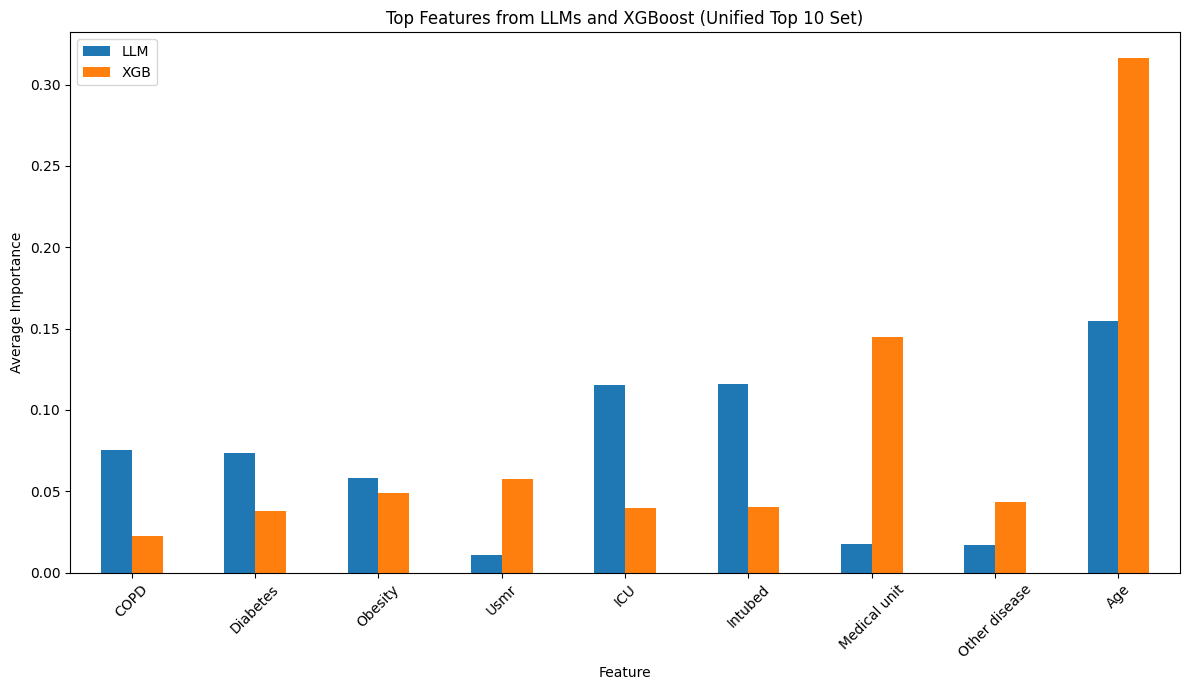

<Figure size 640x480 with 0 Axes>

In [44]:
#average importance per feature
llm_importance = df[df["Model"] != "XGBoost"].groupby("Feature")["Importance"].mean()
xgb_importance = df[df["Model"] == "XGBoost"].groupby("Feature")["Importance"].mean()

# top five from each (1 overlapping leads to 9 top features)
top_llm = llm_importance.sort_values(ascending=False).head(5)
top_xgb = xgb_importance.sort_values(ascending=False).head(5)

#combine unique features from both
top_features = list(set(top_llm.index).union(set(top_xgb.index)))

comparison_df = pd.DataFrame({
    "LLM": llm_importance.reindex(top_features),
    "XGB": xgb_importance.reindex(top_features)
}).fillna(0)

comparison_df.plot.bar(figsize=(12, 7))
plt.ylabel("Average Importance")
plt.title("Top Features from LLMs and XGBoost (Unified Top 10 Set)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("unified_top10_features_llm_vs_xgboost.png")

## Grouped Bar Chart: Average feature importance for top 5 features across Claude, GPT, Deepseek, and XGBoost by gender distribution.

['output_feature_importance_by_gender\\feature_importance_by_gender_allmale.png',
 'output_feature_importance_by_gender\\feature_importance_by_gender_allfemale.png',
 'output_feature_importance_by_gender\\feature_importance_by_gender_allfemalepregnant.png',
 'output_feature_importance_by_gender\\feature_importance_by_gender_genderbalanced.png',
 'output_feature_importance_by_gender\\feature_importance_by_gender_genderunbalanced.png']

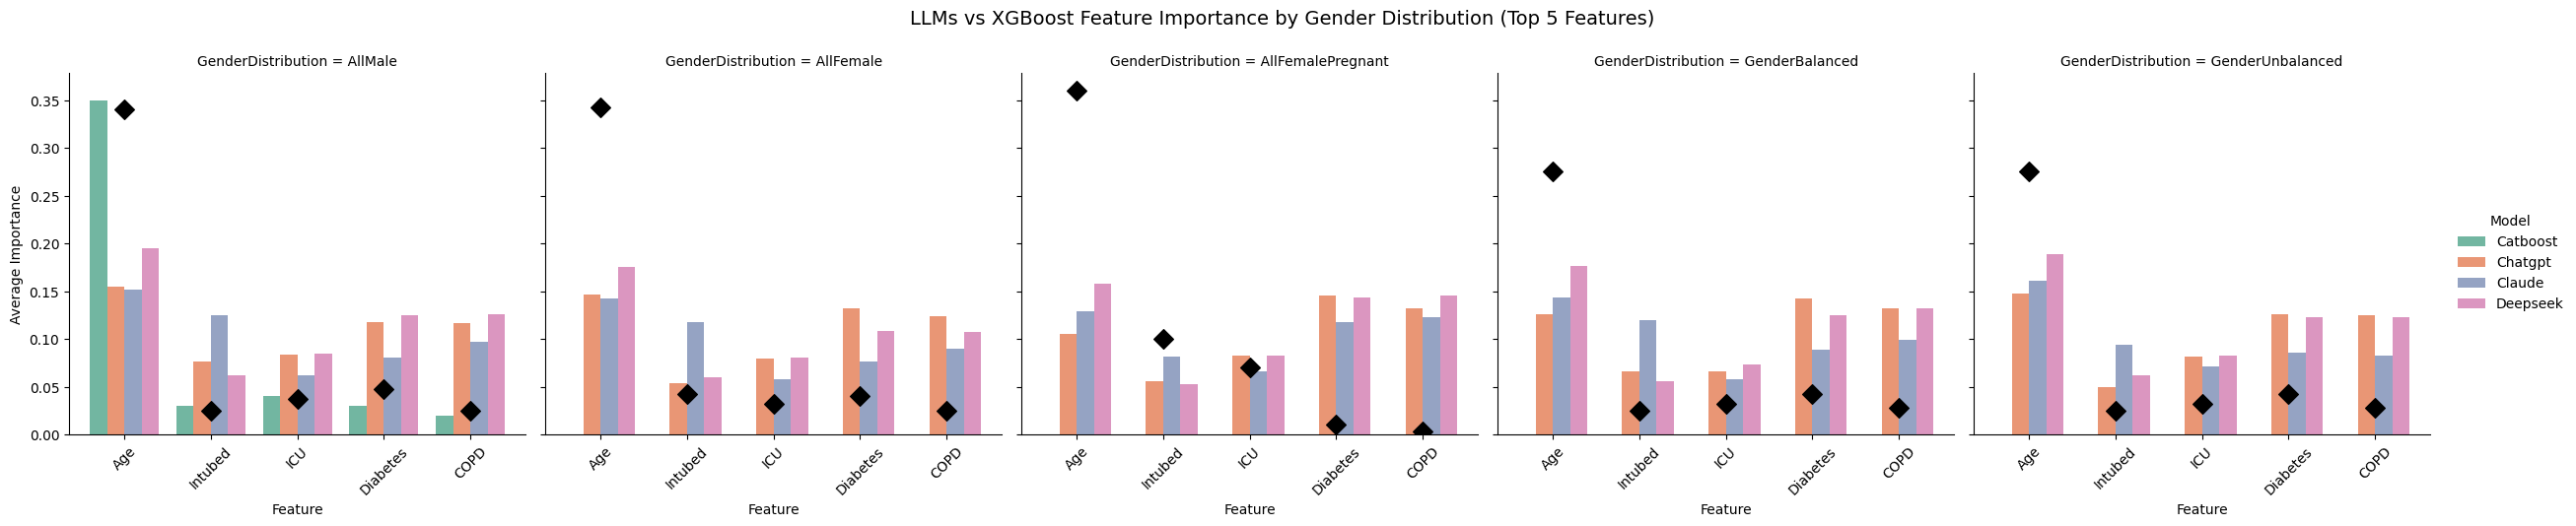

In [ ]:
# Average importance by model, gender, and feature
df_avg = df.groupby(["Model", "GenderDistribution", "Feature"]).Importance.mean().reset_index()

# get top overall 5 features (by average importance)
top_features = df_avg.groupby("Feature")["Importance"].mean().nlargest(5).index
df_top = df_avg[df_avg["Feature"].isin(top_features)]

# Separate LLM and XGBoost data
df_llms = df_top[df_top["Model"] != "XGBoost"]
df_xgb = df_top[df_top["Model"] == "XGBoost"]

# grouped bar char tby gender distribution
g = sns.catplot(
    data=df_llms,
    x="Feature",
    y="Importance",
    hue="Model",
    col="GenderDistribution",
    kind="bar",
    palette="Set2",
    height=5,
    aspect=1
)

# overlay XGboost points manually as black diamond marker
for ax, gender in zip(g.axes.flatten(), df_llms['GenderDistribution'].unique()):
    xgb_subset = df_xgb[(df_xgb["GenderDistribution"] == gender) & (df_xgb["Feature"].isin(top_features))]
    features_order = top_features.tolist()
    xgb_subset = xgb_subset.set_index("Feature").reindex(features_order).reset_index()

    ax.scatter(
        x=range(len(features_order)),
        y=xgb_subset["Importance"],
        color="black",
        marker="D",
        s=100,
        label="XGBoost"
    )
    ax.set_xticks(range(len(features_order)))
    ax.set_xticklabels(features_order, rotation=45)
    ax.set_ylabel("Average Importance")

plt.subplots_adjust(top=0.85)
g.fig.suptitle("LLMs vs XGBoost Feature Importance by Gender Distribution (Top 5 Features)", fontsize=14)

output_dir = "output_feature_importance_by_gender"
os.makedirs(output_dir, exist_ok=True)

facet_paths = []
for i, gender in enumerate(df_llms['GenderDistribution'].unique()):
    ax = g.axes.flatten()[i]
    fig = ax.get_figure()
    
    filename = os.path.join(output_dir, f"feature_importance_by_gender_{gender.lower().replace(' ', '_')}.png")
    fig.savefig(filename)
    facet_paths.append(filename)

facet_paths